# Introduction

The goal of this project is to train a machine learning model that can successfully predict whether or not someone will be approved for a consumer loan. Loan officers typically use a logic-based framework to decide whether or note someone will be approved. This involves calculating debt-to-income (DTI) and evaluating credit reports to see if someone will qualify for a specific loan. The process is not particularly difficult, however, many consumers have poor financial literacy and may not have any idea if they will qualify for a loan before talking to a lender. My aim is to deploy the model so that consumers can easily see if they are likely to qualify for a loan before taking a hit to their credit.

This project has two parts. The first cleans the data and performs analysis to learn more about the data. The second trains and evaluates several machine learning models on the loan data. The data used in this notebook was used with permission from a small credit union. The credit union recently transitioned to a new Loan Origination System (LOS), so there is limited data to train the model. If an accuracy of 90% cannot be acheived, it will note be deployed.

# Data Cleaning

In [1]:
# data manipulation
import pandas as pd
import numpy as np
import regex as re

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in data
df = pd.read_excel('Consumer Loans Application Data.xlsx')

# convert columns and data to lower case
df.columns = [col.lower() for col in df.columns]

df.head()

,viewed,actions,loan product,status,active score,amount approved,amount requested,approved rate,applicant role,ratio - annual income,ratio - credit score,ratio - monthly housing,ratio - monthly income,ratio - monthly other income,ratio - monthly payment requested,ratio - monthly payment decision,ratio - monthly tradeline debt
0,True,NaN,Unsecured/Signature,Declined,746.0,NaN,1000.0,NaN,Primary,18000.0,746.0,0.0,1500.0,1500.0,88.38,NaN,512.0
1,True,NaN,VISA Consumer 9.95,Declined,NaN,NaN,300.0,NaN,Primary,33600.0,NaN,0.0,2800.0,NaN,NaN,NaN,0.0
2,True,NaN,VISA Consumer 9.95,Declined,569.0,NaN,11450.0,NaN,Primary,48000.0,569.0,0.0,4000.0,NaN,NaN,NaN,1187.0
3,True,NaN,RV,Declined,734.0,NaN,30000.0,NaN,Primary,27600.0,734.0,442.0,2300.0,NaN,NaN,NaN,293.0
4,True,NaN,Unsecured/Signature,Declined,NaN,NaN,7500.0,NaN,Primary,19800.0,NaN,0.0,1650.0,250.0,NaN,NaN,0.0


In [3]:
df.tail()

,viewed,actions,loan product,status,active score,amount approved,amount requested,approved rate,applicant role,ratio - annual income,ratio - credit score,ratio - monthly housing,ratio - monthly income,ratio - monthly other income,ratio - monthly payment requested,ratio - monthly payment decision,ratio - monthly tradeline debt
1197,True,NaN,Boat,Approved,NaN,17974.0,17053.0,0.0425,Primary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1198,True,NaN,Auto,Approved,730.0,13000.0,13000.0,0.0285,Primary,37700.0,730.0,300.0,3141.667,NaN,232.73,233.02,0.00
1199,True,NaN,Auto,Approved,732.0,30000.0,30000.0,0.0310,Primary,129600.0,732.0,1600.0,10800.000,10800.0,457.15,457.78,1481.84
1200,True,NaN,Auto,Approved,715.0,5000.0,5000.0,0.0460,Primary,1200.0,715.0,0.0,100.000,NaN,218.46,214.10,44.00
1201,True,NaN,Unsecured/Signature,Approved,604.0,1015.0,1000.0,0.1399,Primary,31200.0,604.0,495.0,2600.000,NaN,NaN,42.43,0.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   viewed                             1202 non-null   bool   
 1   actions                            0 non-null      float64
 2   loan product                       1202 non-null   object 
 3   status                             1202 non-null   object 
 4   active score                       949 non-null    float64
 5   amount approved                    429 non-null    float64
 6   amount requested                   1202 non-null   float64
 7   approved rate                      429 non-null    float64
 8   applicant role                     1202 non-null   object 
 9   ratio - annual income              951 non-null    float64
 10  ratio - credit score               771 non-null    float64
 11  ratio - monthly housing            972 non-null    float

In [5]:
df.shape

(1202, 17)

There are a lot of null values in the dataset and some of the features are redundant. Others have confusing or inaccurate names. I will rename some of the columns, drop redundant data, and fill in missing values where able.

In [8]:
# check some features to see if they contain meaningful information
for col in ['viewed', 'applicant role']:
    print(df[col].value_counts())
    print('\n')

True     1190
False      12
Name: viewed, dtype: int64


Primary    1202
Name: applicant role, dtype: int64




In [9]:
# drop redundant columns
redundant = ['viewed', 'actions', 'applicant role', 'active score']
df.drop(columns=redundant, axis=1, inplace=True)

In [10]:
# remove ratio - from columns names
cols = list(df.columns)
for i in range(len(cols)):
    cols[i] = re.sub('ratio - ', '', cols[i])
df.columns = cols

In [11]:
df.head()

,loan product,status,amount approved,amount requested,approved rate,annual income,credit score,monthly housing,monthly income,monthly other income,monthly payment requested,monthly payment decision,monthly tradeline debt
0,Unsecured/Signature,Declined,NaN,1000.0,NaN,18000.0,746.0,0.0,1500.0,1500.0,88.38,NaN,512.0
1,VISA Consumer 9.95,Declined,NaN,300.0,NaN,33600.0,NaN,0.0,2800.0,NaN,NaN,NaN,0.0
2,VISA Consumer 9.95,Declined,NaN,11450.0,NaN,48000.0,569.0,0.0,4000.0,NaN,NaN,NaN,1187.0
3,RV,Declined,NaN,30000.0,NaN,27600.0,734.0,442.0,2300.0,NaN,NaN,NaN,293.0
4,Unsecured/Signature,Declined,NaN,7500.0,NaN,19800.0,NaN,0.0,1650.0,250.0,NaN,NaN,0.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loan product               1202 non-null   object 
 1   status                     1202 non-null   object 
 2   amount approved            429 non-null    float64
 3   amount requested           1202 non-null   float64
 4   approved rate              429 non-null    float64
 5   annual income              951 non-null    float64
 6   credit score               771 non-null    float64
 7   monthly housing            972 non-null    float64
 8   monthly income             951 non-null    float64
 9   monthly other income       115 non-null    float64
 10  monthly payment requested  463 non-null    float64
 11  monthly payment decision   358 non-null    float64
 12  monthly tradeline debt     964 non-null    float64
dtypes: float64(11), object(2)
memory usage: 122.2+ K

It is clear that we have a lot of missing values. This is understandable, as a loan that is not accepted should not have a value for amount approved. Similarly, not all applicants may have reported income or other income. I'll fill the missing values with 0 and will also convert the "status" column to a binary feature.

In [13]:
df.fillna(0, inplace=True)
df['status'].replace({'Approved': 1, 'Declined': 0}, inplace=True)

# 1. How many loans were approved?

<AxesSubplot:>

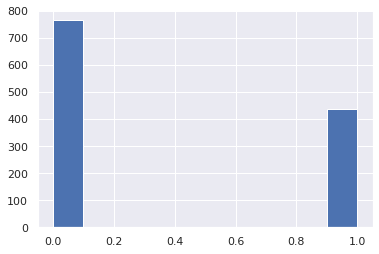

In [14]:
df.status.hist()

In [15]:
declined = df.status.value_counts()[0]
approved = df.status.value_counts()[1]

percent_dec = declined / df.status.size * 100
percent_app = approved / df.status.size * 100

print(f'Number declined: {declined}')
print(f'Number approved: {approved}\n')

print('Percent declined: {:0.1f}%'.format(percent_dec))
print('Percent approved: {:0.1f}%'.format(percent_app))

Number declined: 765
Number approved: 437

Percent declined: 63.6%
Percent approved: 36.4%


# 2. What is the most common type of requested loan?

In [41]:
value_counts = df['loan product'].value_counts()
most_freq_percent = value_counts[0] / df['loan product'].size * 100
most_freq_product = df['loan product'].mode()

print(f'The most common requested loan product is: {most_freq_product[0]} loan')
print(f'{most_freq_percent:.2f}% of all loan applications are for {most_freq_product[0]} loans')

The most common requested loan product is: Auto loan
38.10% of all loan applications are for Auto loans


# 3. What type of loan is most likely to be approved?

In [82]:
pivot = df.pivot_table(values='status', columns='loan product', aggfunc='mean')
pivot = pivot.transpose()
pivot

,status
loan product,
Auto,0.517467
Boat,0.543860
Boat - Variable,0.666667
CD Secured,0.636364
CD Secured (Balloon),1.000000
Credit Builder,0.555556
Personal Line of Credit,0.090909
RV,0.526316
Ready Cash,0.000000


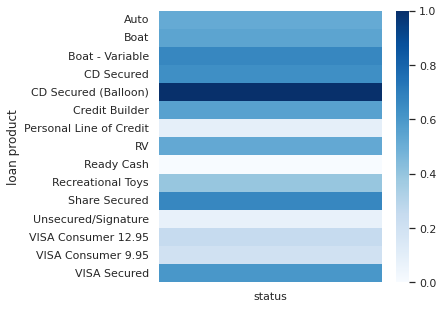

In [81]:
fig,ax=plt.subplots(figsize=(5, 5))
sns.heatmap(pivot,cmap='Blues',ax=ax)
plt.show()

The loan with the best chance of being approved is a CD Secured Balloon loan. This is understandable as CD secured loans offer essentially no risk, because the collateral is funds secured in a CD. Other products that are easy to secure are also more likely to be approved, such as CD Secured, VISA Secured, and Share Secured loans. 

Interestingly, Variable Rate Boat loans are more likely to be approved than their fixed rate counterparts. One possible explanation for this is that variable rates are only used on boats for more expensive, longer term loans. Applicants applying for such an expensive boat may be more likely to have good credit history and income. However, testing this is outside the scope of this analysis.

# 4. What is the most important factor to be approved?

<AxesSubplot:>

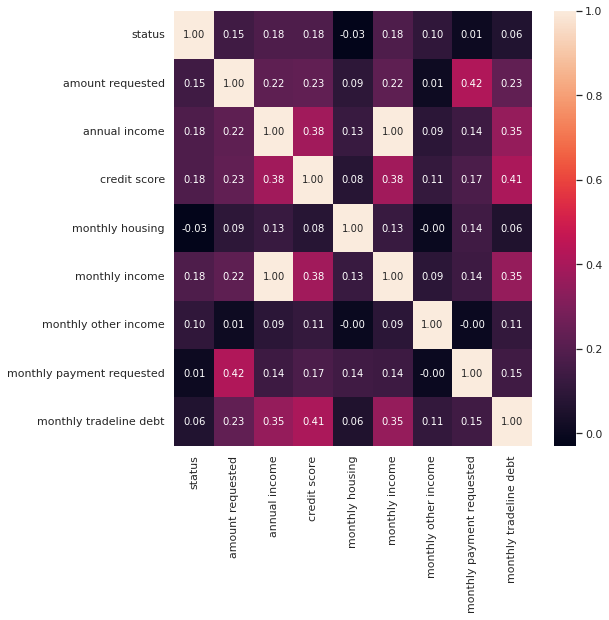

In [83]:
corr_df = df.drop(['amount approved', 'approved rate', 'monthly payment decision'], axis=1)
plt.figure(figsize=(8, 8))
sns.heatmap(corr_df.corr(), annot=True, fmt='.2f')

Once the features that are dependent on approval, such as the approved interest rate, are removed, we can see that there are not any features that are strongly correlated with the loan decision. Income (annual or monthly) and credit are the most important, with a correlation factor of 0.18.

# 5. What is the mean credit score? How does this compare to the national average credit score? 

In [84]:
avg_credit = int(df['credit score'].mean())
national_avg_credit = 698

print(f'Average credit score in data set: {avg_credit}')
print(f'Average credit score in the USA (Experian): {national_avg_credit}')
print('National average data retrieved from https://www.equifax.com/personal/education/credit/score/average-credit-score-state/#:~:text=grant%20you%20credit.-,The%20average%20credit%20score%20in%20the%20United%20States%20is%20698,check%20your%20credit%20scores%20regularly.')

Average credit score in data set: 419
Average credit score in the USA (Experian): 698
National average data retrieved from https://www.equifax.com/personal/education/credit/score/average-credit-score-state/#:~:text=grant%20you%20credit.-,The%20average%20credit%20score%20in%20the%20United%20States%20is%20698,check%20your%20credit%20scores%20regularly.


# 6. What are the mean and median incomes? How does this compare to national averages?

In [86]:
import statistics as stats

avg_income = int(df['annual income'].mean())
med_income = int(stats.median(df['annual income']))

national_avg_income = 51916
national_med_income = 34248

print(f'Average annual income in data set: ${avg_income}')
print(f'Average median income in data set: ${med_income}')
print(f'\nNational average income in the USA: ${national_avg_income}')
print(f'National median income in the USA: ${national_med_income}')
print('\nNational averages retreived from https://policyadvice.net/insurance/insights/average-american-income/#:~:text=What%20is%20the%20average%20American%20Wage%3F,tendency%20for%20all%20the%20data.')

Average annual income in data set: $38876
Average median income in data set: $31200

National average income in the USA: $51916
National median income in the USA: $34248

National averages retreived from https://policyadvice.net/insurance/insights/average-american-income/#:~:text=What%20is%20the%20average%20American%20Wage%3F,tendency%20for%20all%20the%20data.


We can see that the average income for the dataset is significantly lower compared to national averages, while the median is comparable. Income typically has a highly skewed distribution, with a smaller portion of high-income earners bringing up the average. Based on this data, it appears that the economic region this data was gathered from contains a relatively lower concentration of those earners. 

# 7. Are most approved loans approved for the amount requested?

In [87]:
# utility function 
# tests if the approved loan amount is within a given percentage of the requested amount
# returns list of bools
def compare_approval_amount(req, appr, percent):
    is_within_range = []
    for i in range(len(req)):
        within_range = True
        lower = req[i] - req[i] * percent
        if appr[i] < lower:
            within_range = False
        is_within_range.append(within_range)
    return is_within_range

In [111]:
# create inputs for utility function
approved_requested = list(df.loc[df['status']==1]['amount requested'])
approved_approved = list(df.loc[df['status']==1]['amount approved'])
comparison_val = 0.10

# compare whether approved and requested amounts are within a given threshold of each other
comps = compare_approval_amount(approved_requested, approved_approved, comparison_val)

# calculate percentages
num_approved = df.loc[df['status']==1].size

num_true = comps.count(True)
percent_true = num_true / len(comps) * 100

num_false = comps.count(False)
percent_false = num_false / len(comps) * 100

print(f'Out of the {percent_app:.2f}% of loans that were approved, the following percentages reflect \
how many were approved for the requested amount:')

print(f'\n          Approved for an amount 90% or more of the requested amount: {percent_true:.2f}%')
print(f'\n          Approved for an amount less than 90% of the requested amount: {percent_false:.2f}%')

Out of the 36.36% of loans that were approved, the following percentages reflect how many were approved for the requested amount:

          Approved for an amount 90% or more of the requested amount: 96.34%

          Approved for an amount less than 90% of the requested amount: 3.66%


In [112]:
# save cleaned dataframe
df.to_csv('cleaned_consumer_loans.csv')